In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.artist as artist
import matplotlib.patches as patches
from functools import *
from math import *
import pandas as pd
import time
import random
from IPython import display

%matplotlib inline
plt.style.use('ggplot')

In [2]:
size = 4

numNodes = 10
c_v = 0.01

nodeNumList = np.arange(1, numNodes+1, 1)

############## ranges subject to change ###########
# communication range - make sure all nodes are connected
r = 10
# sensing range
r_s = 1.6

# cell k to sense
groundTruthMeasurement = 50
groundTruthLoc = np.matrix([2, 2])

# generate random points
points = size*np.random.rand(2, numNodes)

In [3]:
########################### build graph #########################

# add edge to graph (adding neighbors)
def addEdge(graph, pointIndex, neighborIndex):
    if pointIndex in graph:
        graph[pointIndex].append(neighborIndex)
    else:
        graph[pointIndex] = [neighborIndex]

def distance(point1, point2):
    (x1, y1) = point1
    (x2, y2) = point2
    return (x1-x2)**2+(y1-y2)**2

# go through all nodes to see if neighbor
def findNeighbors(nodeIndex, n, q):
    
    neighborList = []
    q_i = np.array(q[nodeIndex-1]).ravel()

    centerX, centerY = q_i[0], q_i[1]
    for j in range(nodeIndex, n):
        q_j = np.array(q[j]).ravel()
        pointX, pointY = q_j[0], q_j[1]
        if distance((centerX, centerY), (pointX, pointY)) < r**2:
            neighborList.append(j+1)
    return neighborList

# dict[node number] = [neighbors]
# nodes with neighbors
def buildGraph(n, q):
    global fignum
    
    graph = dict()
    
    for i in range(1, n+1):
        centerIndex = i
        q_i = np.array(q[i-1]).ravel()
        centerX, centerY = q_i[0], q_i[1]
        neighbors = findNeighbors(centerIndex, n, q)
        for neighborIndex in neighbors:
            neighbor = neighborIndex-1
            
            q_j = np.array(q[neighbor]).ravel()
            
            pointX, pointY = q_j[0], q_j[1]
            # 3. Link sensor node with neighbor
            plt.plot([centerX, pointX], [centerY, pointY], color='b')
            # add 2 edges for undirected graph
            addEdge(graph, centerIndex, neighborIndex)
            addEdge(graph, neighborIndex, centerIndex)   
        if centerIndex not in graph:
            graph[centerIndex] = []
    
    plt.show()
    return graph

def showSensorNodeGraph(x, y, n, lim):
    fig = plt.figure()
    ax = fig.add_subplot(111)
 
    plt.scatter(2, 2, marker='o', color='blue')
    
    # q: node positions in matrix form
    q = np.column_stack((x, y))
    q = list(map(np.matrix, q))

    plt.scatter(x, y,
                marker='>',
                color='magenta')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])
    # find neighbors for each node
    return buildGraph(n, q)

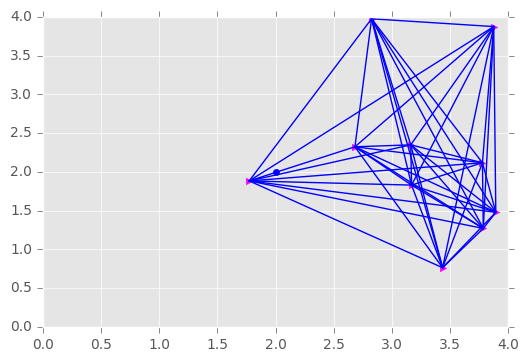

{1: [2, 3, 4, 5, 6, 7, 8, 9, 10], 2: [1, 3, 4, 5, 6, 7, 8, 9, 10], 3: [1, 2, 4, 5, 6, 7, 8, 9, 10], 4: [1, 2, 3, 5, 6, 7, 8, 9, 10], 5: [1, 2, 3, 4, 6, 7, 8, 9, 10], 6: [1, 2, 3, 4, 5, 7, 8, 9, 10], 7: [1, 2, 3, 4, 5, 6, 8, 9, 10], 8: [1, 2, 3, 4, 5, 6, 7, 9, 10], 9: [1, 2, 3, 4, 5, 6, 7, 8, 10], 10: [1, 2, 3, 4, 5, 6, 7, 8, 9]}
q:  [matrix([[ 2.68218781,  2.32369234]]), matrix([[ 1.7728569,  1.8834842]]), matrix([[ 3.87616789,  3.87503092]]), matrix([[ 2.82559058,  3.9753521 ]]), matrix([[ 3.16246604,  2.34882486]]), matrix([[ 3.43630754,  0.76370664]]), matrix([[ 3.7791823 ,  2.11781579]]), matrix([[ 3.78633932,  1.27029513]]), matrix([[ 3.1695948 ,  1.82957773]]), matrix([[ 3.89414055,  1.47842454]])]


In [4]:
nodes = showSensorNodeGraph(points[0], points[1], numNodes, size)
print(nodes)
# q: node positions in matrix form
q = np.column_stack((points[0], points[1]))
q = list(map(np.matrix, q))
print("q: ", q)

In [5]:
#################### Supplemental Functions ########################

def euclideanNorm(q_i, q_j):
    return sqrt(np.sum(np.square(np.subtract(q_i, q_j))))

def sigmaNorm(z, epsilon):
    return 1/epsilon*(sqrt(1+epsilon*(z**2))-1)

def compute_q_mean():
    global q
    return reduce(np.add, q)/numNodes

def compute_c1_w():
    numerator = 2*c_v
    N = numNodes-1
    denominator = N*(r_s**2)
    return numerator/denominator

def compute_c2_w():
    return c_v/(r_s**2)

def random_float(low, high):
    return random.random()*(high-low) + low

def Observability(q_ck, q_i):
    z = euclideanNorm(q_i, q_ck)
    if(z <= r_s):
        return 1
    else:
        return 0
    
def weightDesign_1(i, j):
    observability = (node_observability[i-1] or 
                     node_observability[j-1])
    if i != j and j in nodes[i] and observability:
        return c1_w/(V1[i-1]+V1[j-1])
    elif i == j:
        weight = 0
        for neighbor in nodes[i]:
            weight += weightDesign_1(i, neighbor)
    
        return (1-weight)
    else:
        return 0
    
def weightDesign_2(i, j):
    if i == j and node_observability[i-1]:
        return c2_w/V1[i-1]
    elif i != j and j in nodes[i]:
        return (1-weightDesign_2(i, i))/(len(nodes[i]))
    else:
        return 0
    
def metropolisWeight(i, j):
    observability = node_observability[i-1] or node_observability[j-1]
    if i != j and j in nodes[i] and observability:
        numerator = 1
        denominator = 1 + max(len(nodes[i]), len(nodes[j]))
        return numerator/denominator
    elif i == j:
        result = 1
        for neighbor in nodes[i]:
            result -= metropolisWeight(i, neighbor)
        return result
    else:
        return 0
    
def maxDegreeWeight(i, j):
    if i == j:
        return 1.0 - ((len(nodes[i]) * 1.0) / numNodes)
    else:
        return 1.0 / numNodes  
    
def consensus_update(x, l, weightDesign):
    c_list = []
    for i in range(1, numNodes+1):
        result = weightDesign(i, i)*x[l][i-1]
        
        for j in nodes[i]:
            result += weightDesign(i, j)*x[l][j-1]
        c_list.append(result)
    c_list = list(map(partial(round_decimal, 5), c_list))
    return c_list

def compute_consensus(c_i):
    measurementMean = reduce(lambda x, y: x+y, c_i)/numNodes
    measurementMean = round(measurementMean, 5)
    diff = []
    for i in range(numNodes):
        diff.append(c_i[i]-measurementMean)
    return diff

def round_decimal(places, number):
    return round(number, places)
    

In [6]:
########################### CASE 1 ################################
############ Estimate single cell (single scalar value) ###########

def run_consensus(weightDesign, iterations, title, show):
    global m1
    
    # to store measurements
    x = []
    consensus = []

    # iniital consensus condition
    x.append(m1)

    l = 0
    consensus.append(compute_consensus(x[l]))

    for l in range(iterations):
        x.append(consensus_update(x, l, weightDesign))
        consensus.append(compute_consensus(x[l+1]))

    if show:
        nodeList = np.arange(1, numNodes+1, 1)
        plt.plot(nodeList, x[0], "-ro", label="Initial Measurements")
        plt.plot(nodeList, x[iterations], "-bs", label="Esimated Measurements")

        plt.xlabel("Nodes")
        plt.ylabel("Measurement")

        plt.legend(loc='upper left')
        plt.title(title)
        plt.show()

        P = consensus

        t = np.arange(iterations+1)

        for i in range(numNodes):
            plt.plot(t, P)
        plt.xlabel("Iterations")

        plt.show()
    
    return x

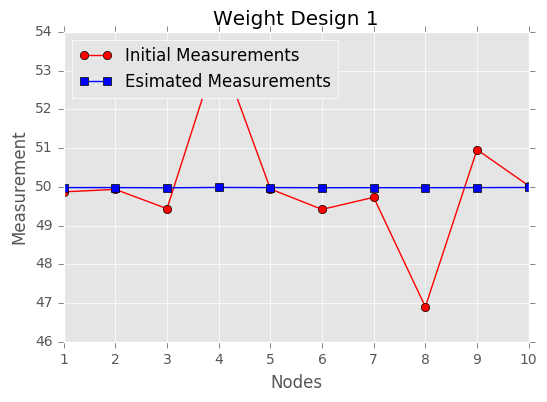

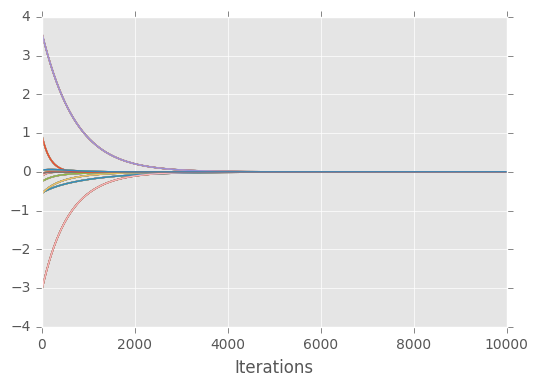

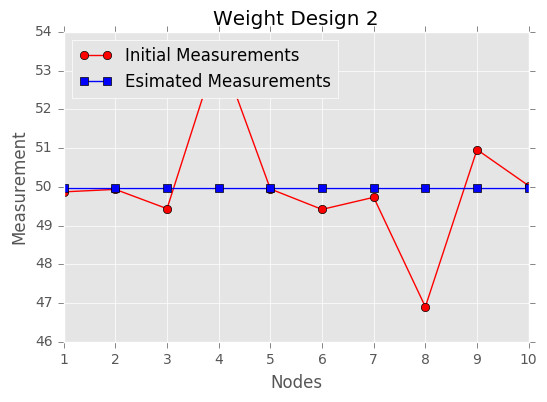

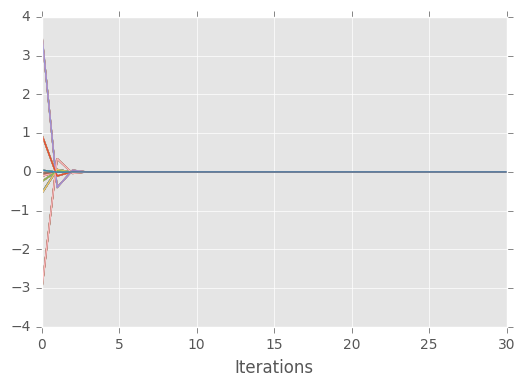

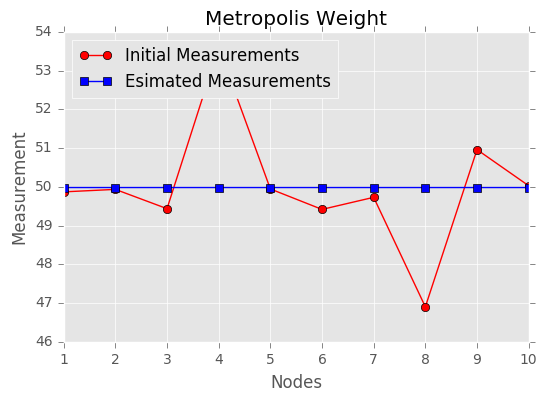

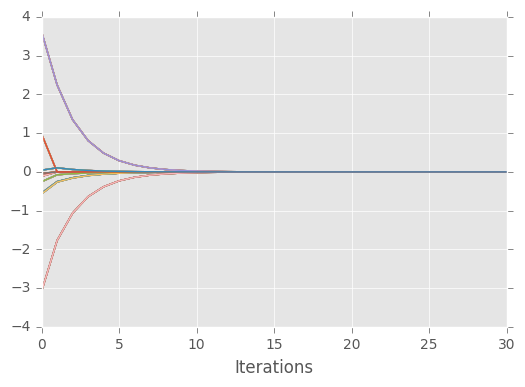

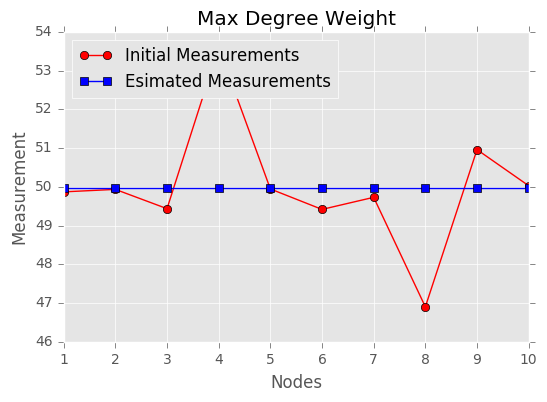

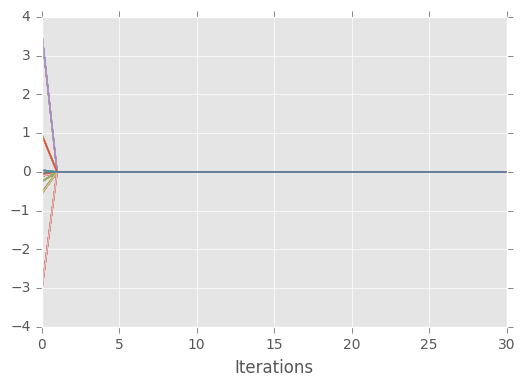

In [7]:
node_observability = list(map(partial(Observability,
                                      groundTruthLoc), q))  
q_mean = reduce(np.add, q)/numNodes
    
c1_w = random_float(0,compute_c1_w())
c2_w = random_float(0, compute_c2_w())
V1 = []
n1 = []
m1 = []

for i in range(numNodes):
    V1.append(((np.linalg.norm(q[i]-groundTruthLoc)**2)+c_v)/(r_s**2))
    n1.append(np.random.normal(0.0, V1[i]))
    m1.append(groundTruthMeasurement+n1[i])
    
m1 = list(map(partial(round_decimal, 5), m1))

# Run consensus for 4 weights
x = run_consensus(weightDesign_1, 10000, "Weight Design 1", True)
x = run_consensus(weightDesign_2, 30, "Weight Design 2", True)
x = run_consensus(metropolisWeight, 30, "Metropolis Weight", True)
x = run_consensus(maxDegreeWeight, 30, "Max Degree Weight", True)

In [8]:
######################### CASE 2 SETUP ################################

size = 12

numNodes = 30
c_v = 0.01

nodeNumList = np.arange(1, numNodes+1, 1)

############## ranges subject to change ###########
# communication range - make sure all nodes are connected
r = 17
# sensing range
r_s = 5

# generate random points
points = size*np.random.rand(2, numNodes)

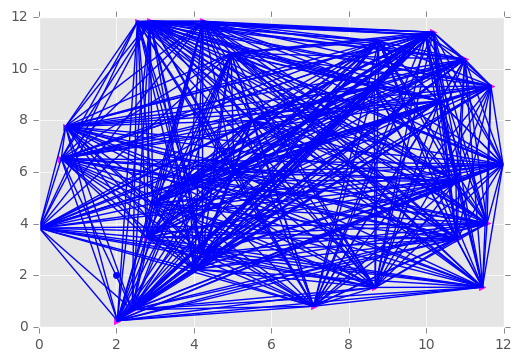

In [9]:
nodes = showSensorNodeGraph(points[0], points[1], numNodes, size)
#print(nodes)
# q: node positions in matrix form
q = np.column_stack((points[0], points[1]))
q = list(map(np.matrix, q))
#print("q: ", q)

In [10]:
q_mean = reduce(np.add, q)/numNodes
    
c1_w = random_float(0,compute_c1_w())
c2_w = random_float(0, compute_c2_w())

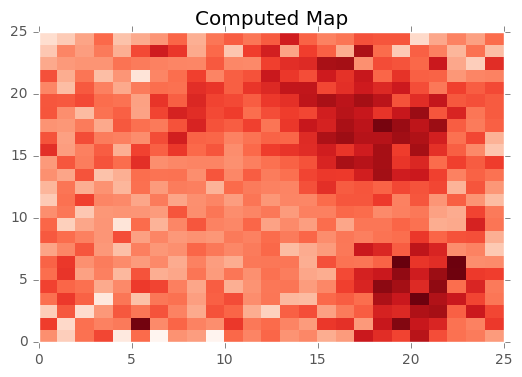

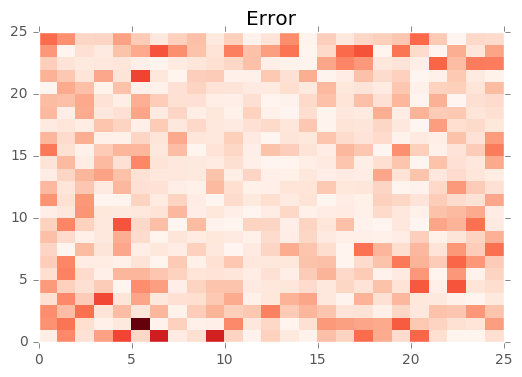

In [11]:
############################# CASE 2 IMPLEMENTATION ###################

FieldData = np.loadtxt("Scalar_Field_data.txt")
DATA_WIDTH = 25
DATA_HEIGHT = 25

ITERATIONS = 100

NUM_NODES = numNodes
newData = np.zeros(shape=(DATA_WIDTH,DATA_HEIGHT))

# Go to each cell and run consensus
for r in range(DATA_HEIGHT):
    for c in range(DATA_WIDTH):
        
        F = FieldData[r][c]
        targetCell = np.array([r * 0.5, c * 0.5])

        node_observability = list(map(partial(Observability,
                                      targetCell), q))  

        V1 = []
        n1 = []
        m1 = []

        for i in range(numNodes):
            V1.append(((np.linalg.norm(q[i]-targetCell)**2)+c_v)/(r_s**2))
            n1.append(np.random.normal(0.0, V1[i]))
            m1.append(F+n1[i])

        m1 = list(map(partial(round_decimal, 5), m1))

        x = run_consensus(weightDesign_2, ITERATIONS, "Weight Design 2", False)

        #Find the estimated value of the cell using the latest iteration
        num = 0
        den = 0
        
        for i in range(1, NUM_NODES+1):
            self_weight = weightDesign_2(i, i)
            num += self_weight * x[ITERATIONS][i-1]
            den += self_weight

        newData[r][c] = num / den

# map
fig, ax = plt.subplots()
heatmap = ax.pcolor(newData, cmap=plt.cm.Reds)
plt.title("Computed Map")
plt.show()

errorData = np.zeros(shape=(DATA_WIDTH,DATA_HEIGHT))

for r in range(DATA_HEIGHT):
    for c in range(DATA_WIDTH):
        errorData[r][c] = abs(newData[r][c] - FieldData[r][c])

#error
fig, ax = plt.subplots()
heatmap = ax.pcolor(errorData, cmap=plt.cm.Reds)
plt.title("Error")
plt.show()